# Ingénierie des Connaissances  
## Atelier : Prédiction floue du risque de panne d’une machine industrielle  

### Objectif  
Concevoir un système intelligent combinant **logique floue** et **Machine Learning** pour estimer le **risque de panne d’une machine** à partir de plusieurs indicateurs incertains (**température**, **vibrations**, **âge**).  

### Vous apprendrez à :  
- Construire un **système d’inférence floue complet**  
- Générer un **jeu de données synthétique** à partir du modèle flou  
- Entraîner un **modèle de Machine Learning** pour généraliser la prédiction  
- **Comparer les deux approches** (logique floue vs ML)  

---

Ce notebook explique pas à pas la création d’un système intelligent combinant **logique floue** et **Machine Learning** pour estimer le risque de panne d’une machine à partir de plusieurs indicateurs incertains (température, vibrations, âge).


##  Étape 1 : Importation des bibliothèques nécessaires

In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

## Étape 2 : Définition des variables floues

### Créez un contrôleur flou avec les variables suivantes :

#### • Entrées :
**➢ Température ∈ [0,100]**
- Basse : [0,0,40]  
- Normale : [30,50,70]  
- Élevée : [60,100,100]  

**➢ Vibration ∈ [0,10]**
- Faible : [0,0,4]  
- Moyenne : [2,5,8]  
- Forte : [6,10,10]  

**➢ Âge ∈ [0,20]**
- Neuf : [0,0,7]  
- Moyen : [5,10,15]  
- Ancien : [12,20,20]  

#### • Sortie :
**➢ Risque de panne ∈ [0,10]**
- Faible : [0,0,4]  
- Moyen : [2,5,8]  
- Élevé : [6,10,10]


In [2]:
temperature = ctrl.Antecedent(np.arange(0, 101, 1), 'temperature')
vibration = ctrl.Antecedent(np.arange(0, 11, 1), 'vibration')
age = ctrl.Antecedent(np.arange(0, 21, 1), 'age')
risque = ctrl.Consequent(np.arange(0, 11, 1), 'risque')

# Fonctions d'appartenance
temperature['basse'] = fuzz.trimf(temperature.universe, [0, 0, 40])
temperature['normale'] = fuzz.trimf(temperature.universe, [30, 50, 70])
temperature['elevee'] = fuzz.trimf(temperature.universe, [60, 100, 100])

vibration['faible'] = fuzz.trimf(vibration.universe, [0, 0, 4])
vibration['moyenne'] = fuzz.trimf(vibration.universe, [2, 5, 8])
vibration['forte'] = fuzz.trimf(vibration.universe, [6, 10, 10])

age['neuf'] = fuzz.trimf(age.universe, [0, 0, 7])
age['moyen'] = fuzz.trimf(age.universe, [5, 10, 15])
age['ancien'] = fuzz.trimf(age.universe, [12, 20, 20])

risque['faible'] = fuzz.trimf(risque.universe, [0, 0, 4])
risque['moyen'] = fuzz.trimf(risque.universe, [2, 5, 8])
risque['eleve'] = fuzz.trimf(risque.universe, [6, 10, 10])

##  Étape 3 : Définition des règles d’inférence floues

### Formulez les règles d’inférence floues qui relient les entrées (**température**, **vibration**, **âge**) à la sortie (**risque**).  
Les règles doivent représenter le raisonnement d’un expert en maintenance.

➢ Si la **température est élevée** ou la **vibration est forte**, alors le **risque est élevé**.  
➢ Si la **machine est ancienne** et la **vibration est moyenne**, alors le **risque est moyen**.  
➢ Si la **température est basse** et la **vibration est faible** et l’**âge est neuf**, alors le **risque est faible**.  
➢ Si la **température est normale** et l’**âge est moyen**, alors le **risque est moyen**.


In [3]:
regle1 = ctrl.Rule(temperature['elevee'] | vibration['forte'], risque['eleve'])
regle2 = ctrl.Rule(age['ancien'] & vibration['moyenne'], risque['moyen'])
regle3 = ctrl.Rule(temperature['basse'] & vibration['faible'] & age['neuf'], risque['faible'])
regle4 = ctrl.Rule(temperature['normale'] & age['moyen'], risque['moyen'])

systeme_ctrl = ctrl.ControlSystem([regle1, regle2, regle3, regle4])

##  Machine Learning

###  Générez 2000 échantillons aléatoires de température, vibration et âge.  
###  Calculez pour chacun la valeur défuzzifiée du risque à partir du modèle flou.  
###  Entraînez ensuite un modèle de régression pour prédire le risque à partir des trois entrées.

Le code suivant permet de générer le jeu de données synthétique à partir du modèle flou :


In [4]:
n = 2000
data = []

for _ in range(n):
    simulation = ctrl.ControlSystemSimulation(systeme_ctrl)
    t = np.random.uniform(0, 100)
    v = np.random.uniform(0, 10)
    a = np.random.uniform(0, 20)
    
    simulation.input['temperature'] = t
    simulation.input['vibration'] = v
    simulation.input['age'] = a
    
    try:
        simulation.compute()
        r = simulation.output.get('risque', np.nan)
    except:
        r = np.nan
    
    data.append([t, v, a, r])

df = pd.DataFrame(data, columns=['Temperature', 'Vibration', 'Age', 'Risque'])
df.dropna(inplace=True)
df.head()

,Temperature,Vibration,Age,Risque
0,77.873151,3.964657,5.083029,8.403980
1,87.603918,0.797733,18.651051,8.568909
2,82.825962,0.512565,11.972147,8.494708
3,90.231575,3.423180,4.372006,8.602756
4,66.443815,4.706838,11.770826,6.054487


##  Étape 5 : Entraînement d’un modèle Machine Learning
On utilise un **Random Forest Regressor** pour apprendre à prédire le risque à partir des trois entrées.

In [5]:
X = df[['Temperature', 'Vibration', 'Age']]
y = df['Risque']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modele = RandomForestRegressor(n_estimators=100, random_state=42)
modele.fit(X_train, y_train)

y_pred = modele.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'R² = {r2:.3f}')
print(f'RMSE = {rmse:.3f}')

R² = 0.991
RMSE = 0.183


##  Étape 6 : Visualisation des résultats
On compare les valeurs du risque flou (réel) et celles prédites par le modèle ML.

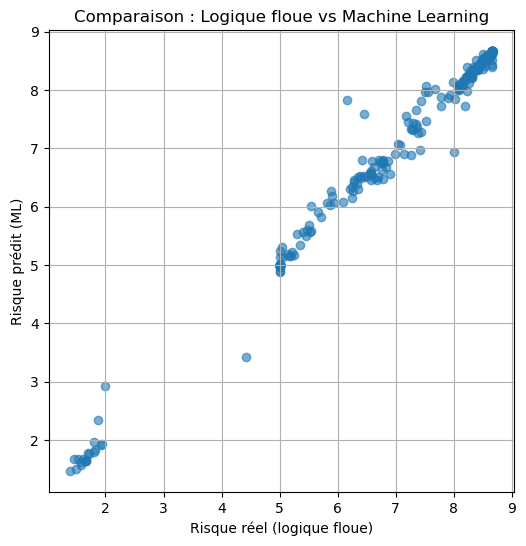

In [6]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Risque réel (logique floue)')
plt.ylabel('Risque prédit (ML)')
plt.title('Comparaison : Logique floue vs Machine Learning')
plt.grid(True)
plt.show()

# Interprétation et Analyse

Dans cette partie, nous comparons les prédictions obtenues avec le système flou et celles du modèle de Machine Learning, et nous discutons les avantages de chaque approche.



**Analyse :**
- Le modèle ML suit globalement les tendances du modèle flou.
- Les légères différences s’expliquent par le fait que le ML généralise à partir des données et peut lisser certaines valeurs.
- Les deux approches permettent d’estimer correctement le risque de panne en fonction des indicateurs incertains.

## 2. Avantages de chaque approche

### Logique floue
-  Transparente et interprétable : les décisions sont basées sur des règles compréhensibles par un expert.
-  Gère l’incertitude et les variables imprécises.
-  Moins précise pour des combinaisons de données non prévues par les règles.

### Machine Learning
-  Précision élevée grâce à l’apprentissage à partir de nombreux exemples.
-  Capacité de généralisation à de nouvelles combinaisons de valeurs.
-  Moins interprétable : le modèle est une “boîte noire”.

## 3. Conclusion

Le système flou est idéal pour comprendre le raisonnement d’experts et gérer l’incertitude, tandis que le modèle ML permet d’automatiser les prédictions et d’améliorer la précision sur un grand nombre de données.  
L’association des deux approches combine les avantages de la transparence et de la précision.
